In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

2023-01-25 11:11:02.085162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 11:11:02.278755: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-25 11:11:03.232608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/compiler/gnu/12.1.0/lib64:/opt/bwhpc/common/compiler/intel/2022.2/compiler/2022.1.0/linux/lib:/opt/bwhpc/common/compiler/intel/2022.2/compiler/2022.1.0/linux/lib/x64:/opt/bwhpc/common/compiler/i

In [2]:
save_figs = True
fig_path = "./figures"
if save_figs:
    os.makedirs(fig_path, exist_ok=True)

In [3]:
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_losses

from utility_functions import feather_loader
# customized plotting functions
from plotting_functions import compare_estimates, plot_recovery

/gpfs/bwfor/home/hd/hd_hd/hd_fy224/BayesFlow/bayesflow/trainers.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Simple drift-diffusion model: Globally Amortized Bayesian Likelihood and Posterior Inference

In this tutorial, we want to show the potential of learning both the posterior network and the surrogate likelihood. The resulting distributions are validated using SBC. Additionally, the estimates are compared to Stan estimates. The likelihood is compared to the true likelihood. Marginal likelihood and leave-one-out cross-validation (LOO) are calculated and compared to bridgesampling and Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO) respectively.

## The drift-diffusion model
We use the simple drift-diffusion model as a toy example, as it has a tractable likelihood and can be calculated comparatively quickly. The model consists of four parameters: drift-rate $v$, boundary separation $a$, non-decision time $t_0$ and bias (relative starting point) $w$. We won't cover the model in detail here, but there is a vast literature explaining the model and the effects of its parameters. It has the particularity of being very sensible to early outliers, as all reaction times smaller than the non-decision time are considered impossible (i.e. have a likelihood of zero).

In [4]:
param_names = ["v", "a", "t0", "w"]

## Posterior network
We want to train a posterior network that maps input data to the corresponding posterior distribution over the parameters. The network is trained using presimulated data, here we use the `rtdists` R-package for the simulations. Refer to `presimulation_posterior.R` for details. The prior distribution for the parameters is

- $v \sim \mathcal{N}(0, 10)T[-5,5]$
- $a \sim \mathcal{N}(1, 1)T[0.5,3]$
- $t_0 \sim \mathcal{N}(0.4, 0.2)T[0.2,1]$
- $w \sim \mathcal{N}(0.5, 0.1)T[0.3,0.7]$

where $T[\text{lower},\text{upper}]$ denotes a truncation. Using truncated priors is practical, as it allows us to constrain the parameter range we need a likelihood network for.

In [5]:
prior_dist = tfp.distributions.TruncatedNormal(
    loc=[0, 1, 0.4, 0.5],
    scale=[10, 1, 0.2, 0.1],
    low=[-5, 0.5, 0.2, 0.3],
    high=[5, 3.0, 1.0, 0.7]
)

2023-01-25 11:11:05.486566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 11:11:05.860997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43458 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6


We use an invariant network as summary network to account for the i.i.d. structure of the data. An invertible network with 5 coupling layers is used as inference network. Additionally, we use a multivariate Student's t-distribution as latent distribution (instead of the usual normal distribution), as this seems to make training more robust.

We can vary the trial number$ N$ so the amortization generalizes over different trial numbers. To do this, we have to supply the number of trials to the amortized posterior via `direct_conditions`. As integers can cause problems when using neural networks, we will supply $\log N$ instead. Given that information, the posterior network can learn the correct contraction.

In [6]:
def configurator_posterior(forward_dict, min_trials=80, max_trials=120):
    """ Configures simulator outputs for use in BayesFlow training."""
    N = np.random.randint(min_trials, max_trials + 1)

    input_dict = {}
    input_dict['parameters'] = forward_dict['prior_draws'].astype(np.float32)
    input_dict['summary_conditions'] = forward_dict['sim_data'][:,:N,1:].astype(np.float32)
    
    # supply trial number to posterior network
    batch_size = forward_dict['prior_draws'].shape[0]
    # number of trials (identical for the whole batch)
    N_ones = np.ones((batch_size, 1))
    # supply the logarithmized number of trials directly to the inference network 
    input_dict['direct_conditions'] = (N_ones * np.log(N)).astype(np.float32)
    return input_dict

For the code to train the network, see `train_posterior.py`. After training, we can load the trained network from the last checkpoint:

In [7]:
from tensorflow_probability import distributions as tfd
# specify network architecture
summary_net = InvariantNetwork()
# Robust model training and generalisation with Studentising flows: https://arxiv.org/pdf/2006.06599.pdf
df = 50
mvt = tfd.MultivariateStudentTLinearOperator(
    df=df,
    loc=np.zeros(len(param_names), dtype=np.float32),
    scale=tf.linalg.LinearOperatorDiag(np.ones(len(param_names), dtype=np.float32))
)
inference_net = InvertibleNetwork(
    num_params=len(param_names),
    num_coupling_layers=5
)

amortized_posterior = AmortizedPosterior(inference_net, summary_net, latent_dist=mvt)

# load from checkpoint
trainer_posterior = Trainer(
    amortizer=amortized_posterior,
    checkpoint_path="checkpoints/posterior_80_120"
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from checkpoints/posterior_80_120/history_100.pkl.
INFO:root:Loaded simulation memory from checkpoints/posterior_80_120/memory.pkl
INFO:root:Networks loaded from checkpoints/posterior_80_120/ckpt-100


To make sure that the training has converged, we can take a quick look at the loss history.

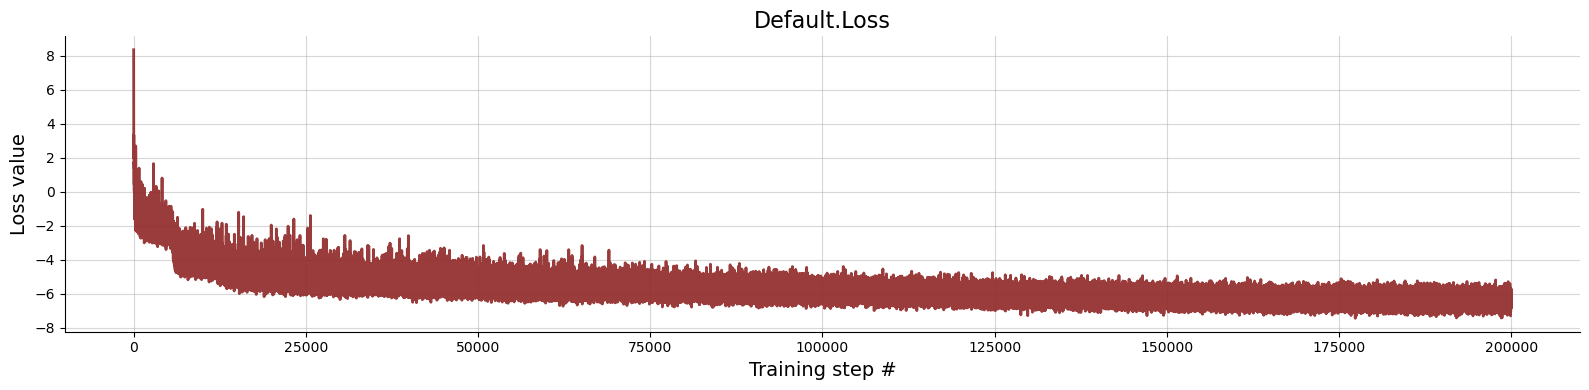

In [8]:
f = plot_losses(trainer_posterior.loss_history.get_plottable())

## Likelihood network

The amortized likelihood needs at minimum two inputs, as the invertible coupling layers don't work for single inputs. Normally, the drift diffusion gives only one output, a combination of response and reaction time where the lower boundary is coded as negative reaction time. Here we set two anyway, and later a dummy variable that is normally distributed and independent of the parameters. To do this, we use a configurator which adds the dummy variable to the input of the likelihood network.

In [9]:
def configurator_likelihood(forward_dict, num_trials, dummy_random=True):
    """ Configures simulator outputs for use in BayesFlow training."""
    sim_data = forward_dict['sim_data'][:,:num_trials,1]
    
    # We need two variables, but reaction times are only one
    # -> Create dummy variable
    if dummy_random:
        dummy = np.random.default_rng().normal(0, 1, sim_data.shape)
    else:
        dummy = np.zeros_like(sim_data)

    input_dict = {}
    input_dict['conditions'] = forward_dict['prior_draws'].astype(np.float32)
    input_dict['observables'] = np.stack((sim_data, dummy), axis=-1).astype(np.float32)
    return input_dict

As we have a low number of parameters and a low number of features, we reduce the number of units in the coupling layers. We use the tanh activation function, which seemed to perform well in our tests. Again, we use a multivariate Student's t-distribution as latent distribution. To make sure the parameter space of interest is well covered, we sample from a uniform priors spanning a slightly larger space than what we used in the posterior network, namely

- $v \sim \text{Uniform}(-5.5, 5.5)$
- $a \sim \text{Uniform}(0.4, 3.1)$
- $t_0 \sim \text{Uniform}(0.1, 1.1)$
- $w \sim \text{Uniform}(0.28, 0.721)$

As learning an exact approximation of the complete likelihood is quite complicated, a larger amount of training data and a larger amount of layers is required. We load the trained network, refer to `train_likelihood.py` for the training code.

In [10]:
# specify the network architecture
coupling_net_settings={
    't_args': {
        'dense_args': dict(units=32, kernel_initializer='glorot_uniform', activation='tanh'),
        'num_dense': 2,
        'spec_norm': False
    },
    's_args': {
        'dense_args': dict(units=32, kernel_initializer='glorot_uniform', activation='tanh'),
        'num_dense': 2,
        'spec_norm': False
    },
}
likelihood_net = InvertibleNetwork(num_params=2, num_coupling_layers=12, coupling_net_settings=coupling_net_settings)

# Robust model training and generalisation with Studentising flows: https://arxiv.org/pdf/2006.06599.pdf
df = 50
mvt = tfd.MultivariateStudentTLinearOperator(
    df=df,
    loc=np.zeros(2, dtype=np.float32),
    scale=tf.linalg.LinearOperatorDiag(np.ones(2, dtype=np.float32))
)

amortized_likelihood = AmortizedLikelihood(likelihood_net, latent_dist=mvt)

# load from checkpoint
trainer_likelihood = Trainer(
    amortizer=amortized_likelihood,
    checkpoint_path="checkpoints/likelihood/"
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from checkpoints/likelihood/history_20.pkl.
INFO:root:Loaded simulation memory from checkpoints/likelihood/memory.pkl
INFO:root:Networks loaded from checkpoints/likelihood/ckpt-20


Again, an inspection of the loss indicates no convergence problems:

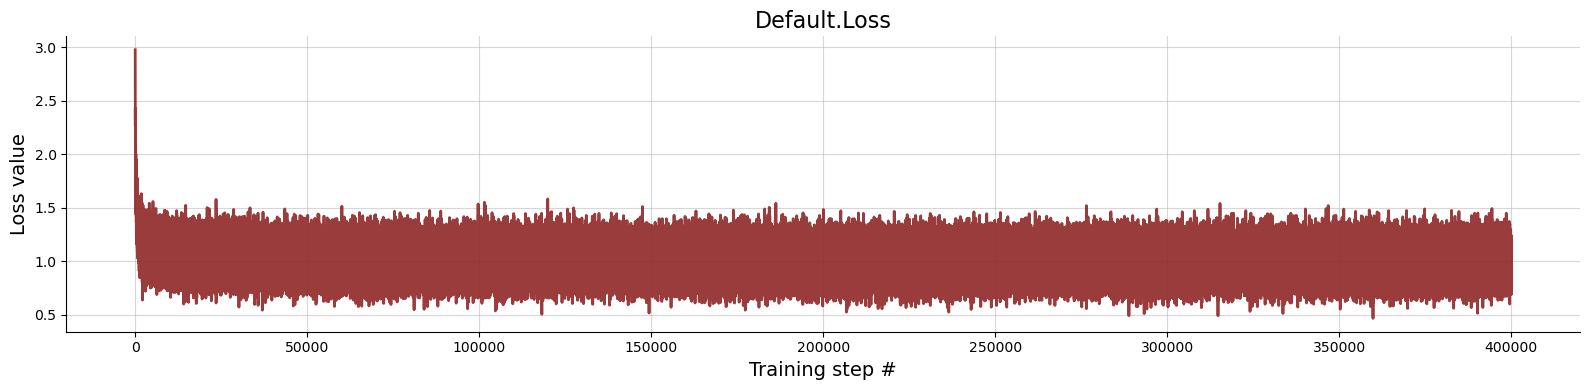

In [11]:
f = plot_losses(trainer_likelihood.loss_history.get_plottable())

## Validation: Checking the calibration of the networks

We first load a validation data set, simulated using the same simulator and priors as the training data for the posterior network. For validation and later comparison to Stan, from now on the dummy variable will always be set to 0. For the log-likelihoods, this results in a constant shift of $\log \mathcal N (0|0,1)\approx -0.919$. In the following, we will work with a trial number of 100, but other trial numbers in the trained range could be used as well.

In [12]:
# Number of data sets to use for calibration
N_CALIB = 5000
# Number of data sets used for comparison plots and recovery
N_REC = 100
# Number of posterior samples to use
N_POSTERIOR_DRAWS = 1000
# Load left-out validation data
val_data = feather_loader("assets/evaluation/sim_data/01.feather",
                          param_names, num_simulations=N_CALIB)
# Call configurator to bring the data into the required form
val_dict = {
    'posterior_inputs': configurator_posterior(val_data, min_trials=100, max_trials=100),
    'likelihood_inputs': configurator_likelihood(val_data, num_trials=100, dummy_random=False)
}
# extract the prior samples
prior_samples = val_dict['posterior_inputs']['parameters']

In [13]:
val_dict['likelihood_inputs']['conditions'].shape, \
val_dict['likelihood_inputs']['observables'].shape, \
val_dict['posterior_inputs']['summary_conditions'].shape, \
val_dict['posterior_inputs']['direct_conditions'].shape

((5000, 4), (5000, 100, 2), (5000, 100, 1), (5000, 1))

### Posterior network
To check the calibration of the posterior network, we use the data from the simulator to do a simulation based calibration. Below, the rank ECDF is used to assess calibration. We can see that no systematic deviations occur, so this measure is indicating no calibration problems.

In [14]:
# Sample from posterior given simulator outputs
post_samples_sim = amortized_posterior.sample({
    'direct_conditions': val_dict['posterior_inputs']['direct_conditions'],
    'summary_conditions': val_dict['posterior_inputs']['summary_conditions']
}, n_samples=N_POSTERIOR_DRAWS)

2023-01-25 11:11:09.173108: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


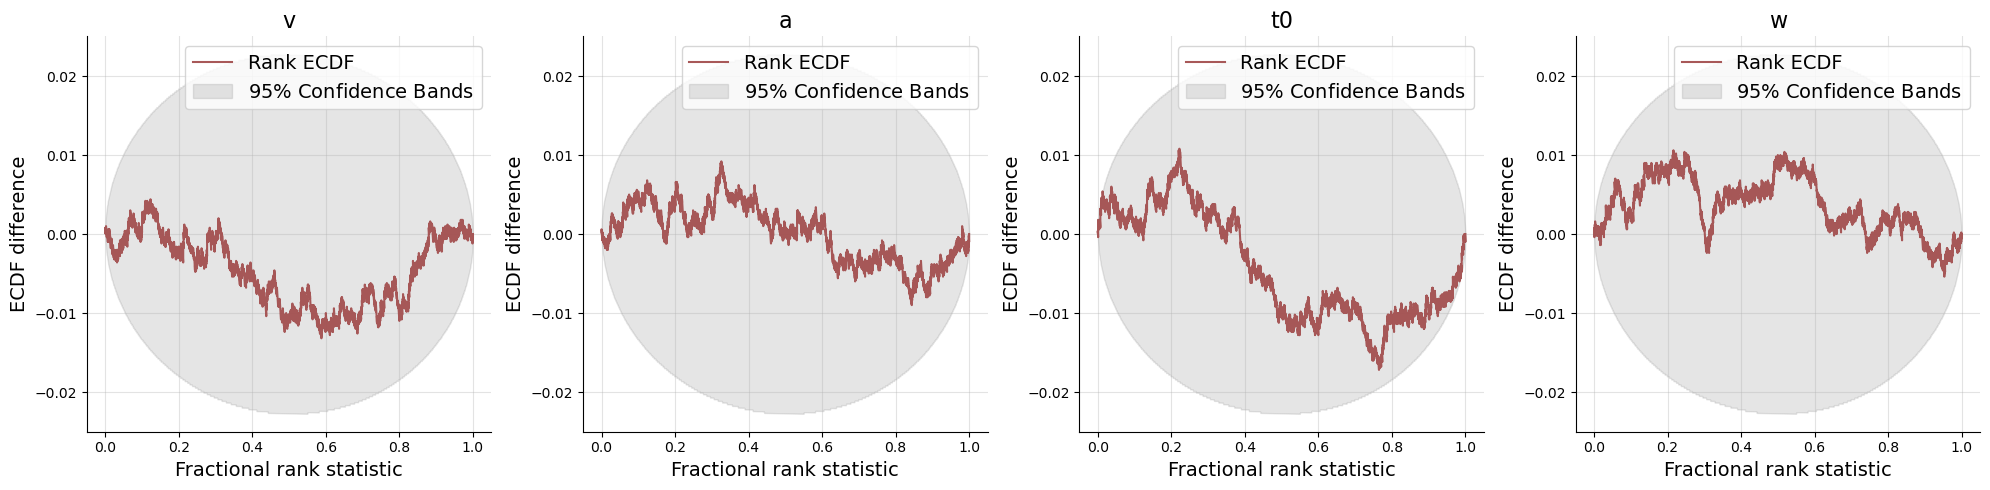

In [15]:
f = plot_sbc_ecdf(post_samples_sim, prior_samples, param_names=param_names, difference=True, alpha=0.95)
if save_figs: f.savefig(f'{fig_path}/ECDF_Posterior.pdf', dpi=300)

### Likelihood network: Joint calibration
As we have already validated that the posterior network performs as expected, we can now check the calibration of the surrogate likelihood. To do this, we sample data for given parameters and again do a simulation based calibration. If the likelihood corresponds to the likelihood used to simulate the training data, we again should see good calibration. If not, we know that there may be a problem with the likelihood network. This showcases a key advantage of the combination of amortized posterior and amortized likelihood. We can use the first to efficiently assess the calibration of the second. This can be important if the necessary network/training characterstics are unclear (as was the case here as well), so one can adapt those until a sufficiently well calibrated likleihood network can be obtained.

In [16]:
# Simulate from surrogate simulator, identical number of trials to make sure that direct_conditions match
x_sim_sur = amortized_likelihood.sample({'conditions': val_dict['likelihood_inputs']['conditions']},
                                        n_samples=val_dict['likelihood_inputs']['observables'].shape[1])

In [17]:
# Sample from posteriors given surrogate outputs
post_samples_sur = amortized_posterior.sample({
    'direct_conditions': val_dict['posterior_inputs']['direct_conditions'],
    'summary_conditions': x_sim_sur[:,:,:1]
}, n_samples=N_POSTERIOR_DRAWS)

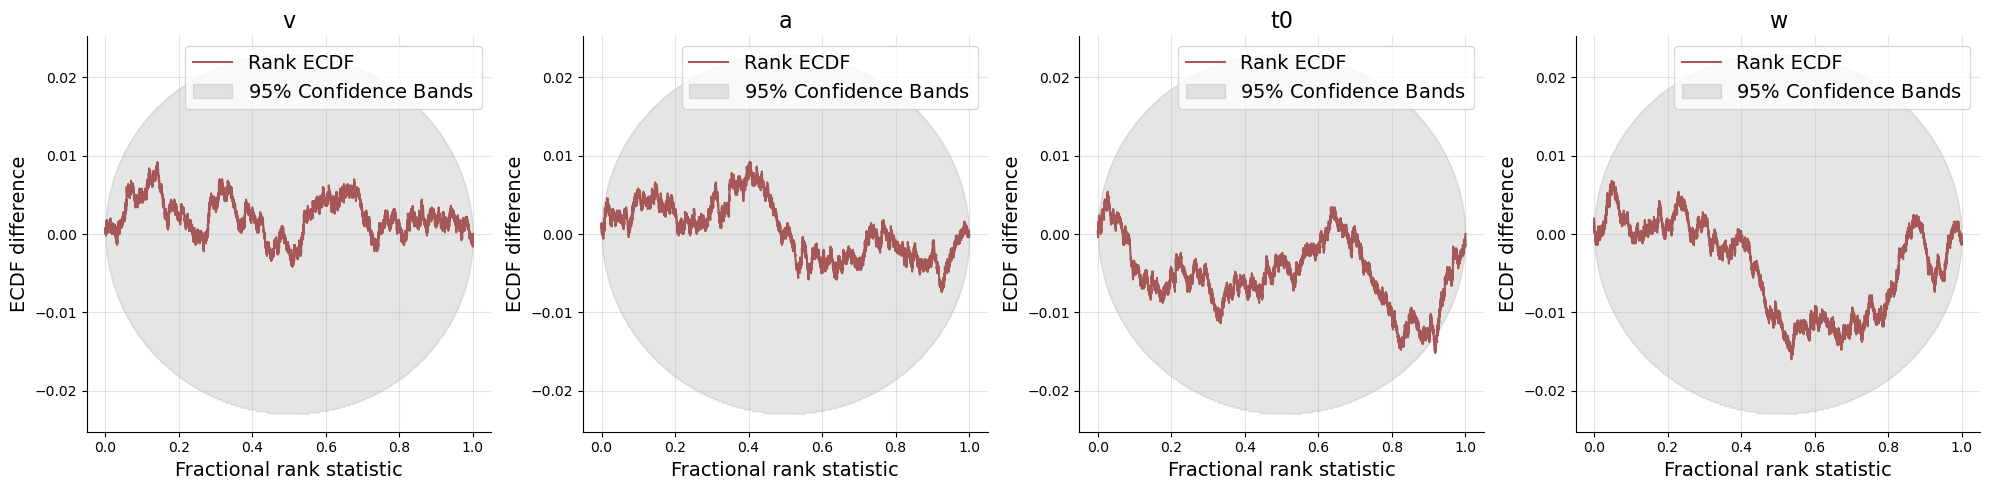

In [18]:
f = plot_sbc_ecdf(post_samples_sur, prior_samples, param_names=param_names, difference=True, alpha=0.95)
if save_figs: f.savefig(f'{fig_path}/ECDF_Joint.pdf', dpi=300)

For this combination of likelihood network and posterior network, the SBC shows good calibration for some runs and a slight miscalibration for others. As the posterior network showed good calibration, this indicates that the likelihood network might be slightly miscalibrated. As the deviations are small, we will continue wit this network. If one was concerned by this behavior, one could retrain with a larger network or more iterations.

## Testing the recovery
To see whether the model is able to recover the parameters given the simulated data, we can plot the ground truth against the estimates. A lower number of data sets is chosen so that single points are visible. Especially for the bias $w$, we can observe the effect of the prior on the posterior distributions. Extremely high and extremely low values are deviated towards values with higher prior probability. This is what we would expect and in fact would hope to happen, given that we supplied only limited data.

To summarise the posterior distribution, we use the median and a 90%-equal-tailed interval. We define the latter as a function for easier access:

In [19]:
def equal_tailed(data, axis, alpha=0.1):
    return np.abs(np.quantile(data, [alpha/2, 1-alpha/2], axis=axis)
                  - np.median(data, axis=axis))

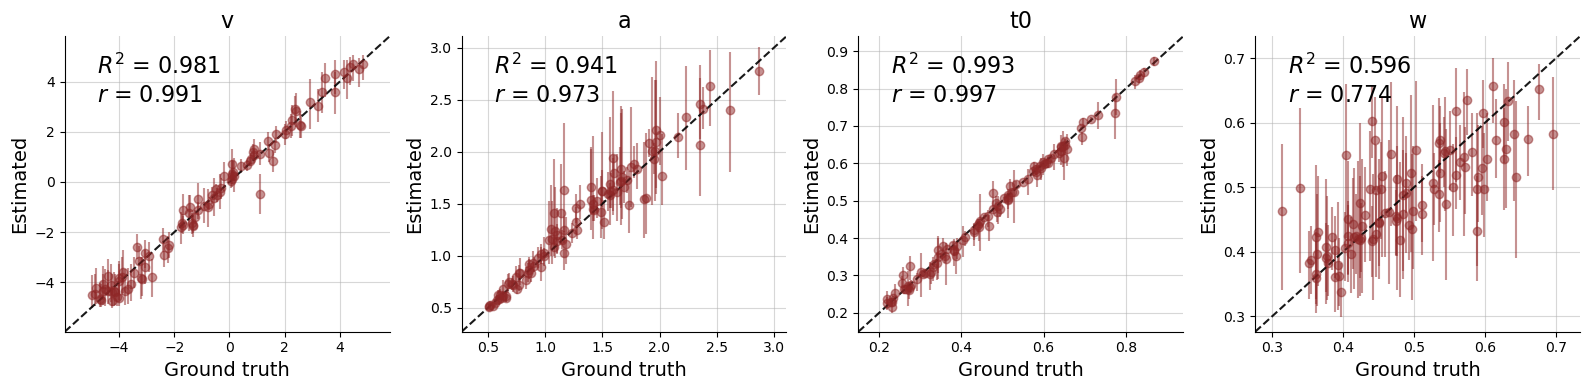

In [20]:
f = plot_recovery(post_samples_sim[:N_REC], prior_samples[:N_REC], param_names=param_names,
                  point_agg=np.median, uncertainty_agg=equal_tailed)
if save_figs: f.savefig(f'{fig_path}/BayesFlow_recovery.pdf', dpi=300)

## Compare to Stan

The recovery is a measure that depends on the prior, the model and the data, but should be independent of the method used to compute the posterior distribution. To see whether this is the case, we fit the same data using a Stan model. Below, we load the posterior samples of those fits. As the Stan model uses the correct likelihood function (constructed using the `wiener_lpdf` function) and a state-of-the-art MCMC sampler (NUTS), we can use it as a reference or "upper bound" of what we can expect from the posterior network.

In [21]:
# Load smaller file (only samples for 100 data sets) only for comparison
samples_stan = np.load("assets/samples_stan_small.npy")

As can be seen below, the recovery looks very similar. One can easily see single corresponding estimates in both graphs.

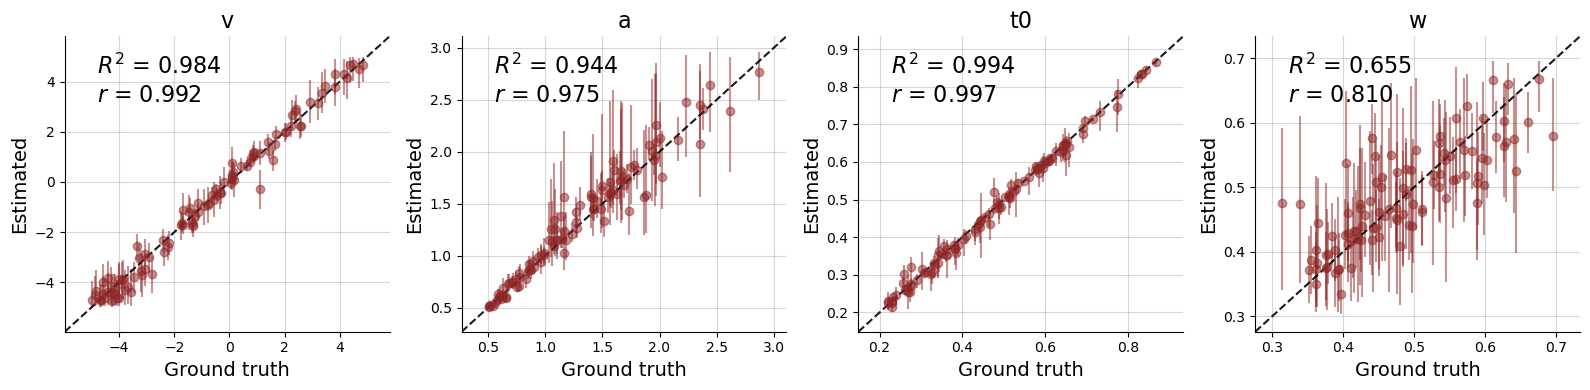

In [22]:
f = plot_recovery(samples_stan[:N_REC], prior_samples[:N_REC], param_names=param_names,
                  point_agg=np.median, uncertainty_agg=equal_tailed)
if save_figs: f.savefig(f'{fig_path}/Stan_recovery.pdf', dpi=300)

We can also check the calibration of the Stan samples, so we know that the Stan model corresponds well to the simulator.

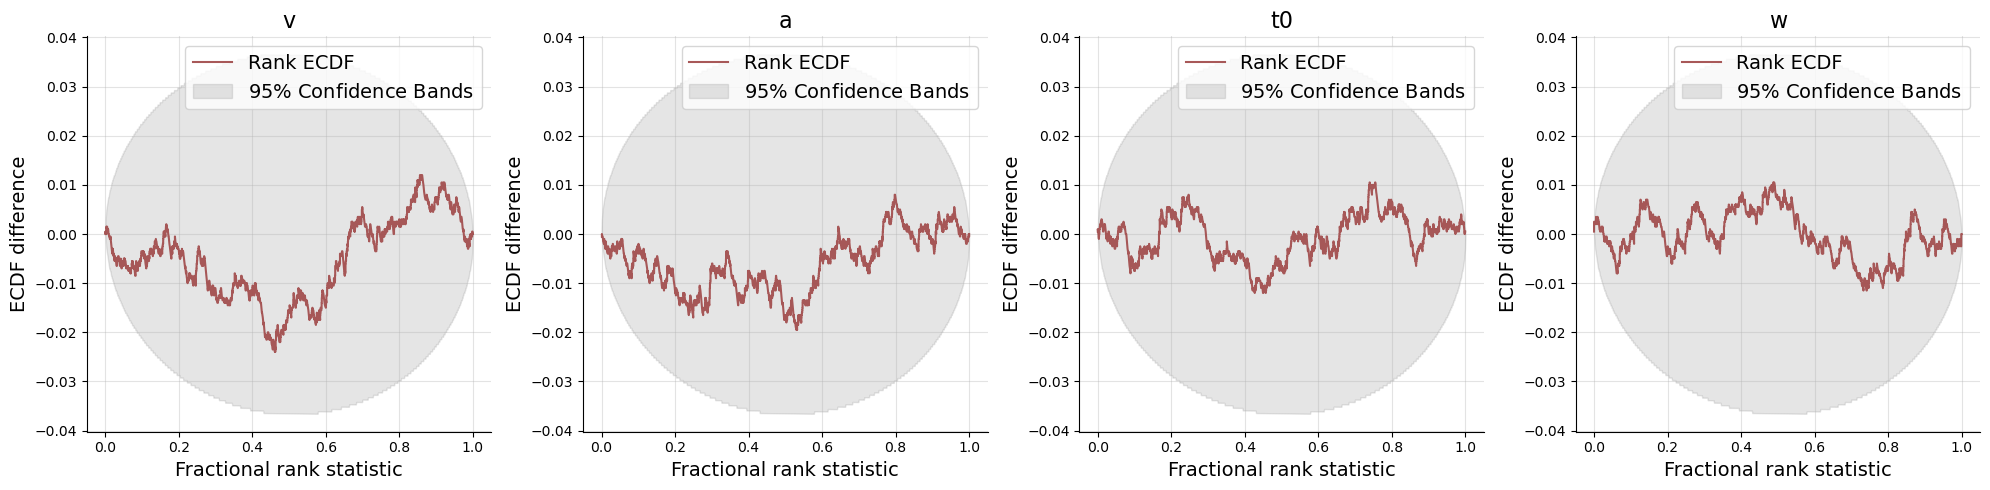

In [23]:
# load larger file (samples for 2000 data sets) as calibration requires many data sets
samples_stan = np.load("data/osfstorage/fits_stan/samples_100.npy")
f = plot_sbc_ecdf(samples_stan[:2000], prior_samples[:2000], difference=True, param_names=param_names)
if save_figs: f.savefig(f'{fig_path}/Stan_ECDF.pdf', dpi=300)

Finally, we can compare the posterior medians for the estimates of Stan and BayesFlow. This gives a first impression of the correspondance of both methods. As this is only a summary measure, it doesn't tell us whether the whole posterior distributions correspond well, but the combination of calibration and posterior medians should be sufficient for this example. We see good correspondance, $w$ seems to be the hardest to learn for the posterior network. This will probably improve with more training data, up to a certain point where the signal from the data is just not strong enough to learn it perfectly.

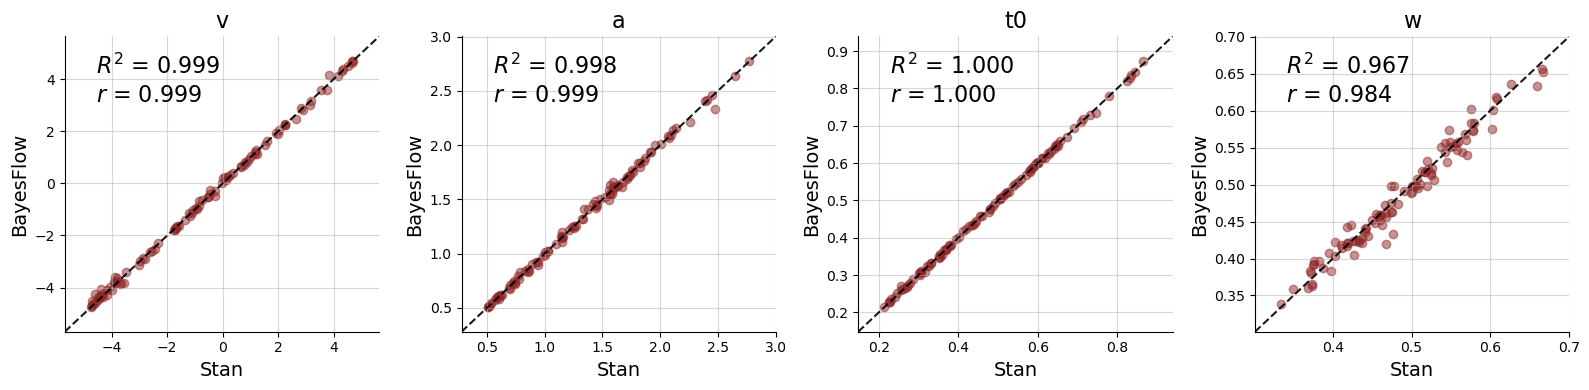

In [24]:
from plotting_functions import compare_estimates
f = compare_estimates(samples_stan[:N_REC], post_samples_sim[:N_REC],
                      point_agg=np.median, uncertainty_agg=None,
                      label_x = "Stan", label_y = "BayesFlow", param_names = param_names)
if save_figs: f.savefig(f'{fig_path}/Stan_BayesFlow_median_comparison.pdf', dpi=300)

To provide additional information, we can add the 90%-equal-tailed interval of the posterior samples to the plot. It's not that easy to distinguish, but we can see (at least for $w$) that the deviation of the posterior medians is small compared to the uncertainty around the median. Additionally, we see good correspondance of the error bars, indicating similar 90%-intervals for both estimation methods.

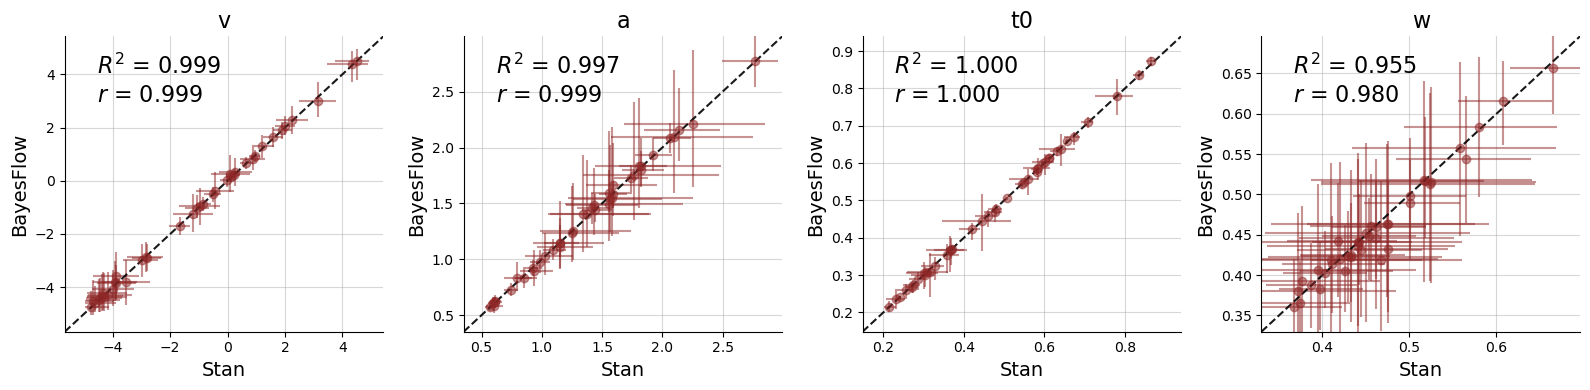

In [25]:
from scipy.stats import median_abs_deviation
f = compare_estimates(samples_stan[:40], post_samples_sim[:40],
                      point_agg=np.median, uncertainty_agg=equal_tailed,
                      label_x = "Stan", label_y = "BayesFlow", param_names = param_names)
if save_figs: f.savefig(f'{fig_path}/Stan_BayesFlow_median_comparison_uncertainty.pdf', dpi=300)

## Comparing to the true likelihood
`WienR` provides the likelihood (and the derivatives) of the diffusion model. We can use it to compare the learned likelihood with the correct likelihood. As `WienR` is an R package (it can be installed using `install.packages('WienR')`), we use `rpy2` to access R from Python.

In [26]:
from rpy2 import robjects
from rpy2.robjects import r
from rpy2.robjects.vectors import FloatVector

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /opt/bwhpc/common/math/R/4.2.1-mkl-2022.2-gnu-12.1-cairo/lib64/R
INFO:rpy2.situation:R library path: /opt/bwhpc/common/math/R/4.2.1-mkl-2022.2-gnu-12.1-cairo/lib64/R/lib:/opt/bwhpc/common/compiler/intel/2022.2/mkl/2022.1.0/lib/intel64:/gpfs/bwfor/software/common/compiler/intel/2022.2/mkl/2022.1.0/lib/intel64:/opt/bwhpc/common/compiler/gnu/12.1.0/lib64:/opt/bwhpc/common/compiler/intel/2022.2/compiler/2022.1.0/linux/lib:/opt/bwhpc/common/compiler/intel/2022.2/compiler/2022.1.0/linux/lib/x64:/opt/bwhpc/common/compiler/intel/2022.2/compiler/2022.1.0/linux/compiler/lib/intel64_lin:/opt/bwhpc/common/compiler/intel/2022.2/tbb/2021.6.0/lib/intel64/gcc4.8:/opt/bwhpc/common/compiler/intel/2022.2/mkl/2022.1.0/lib/intel64:/opt/bwhpc/common/math/R/4.2.1-mkl-2022.2-gnu-12.1-cairo/lib64/R/lib:/opt/bwhpc/common/math/R/4.2.1-mkl-2022.2-gnu-12.1-cairo/lib64:/opt/bwhpc/common/devel/cuda/11.6.1/lib64:/opt/bwhpc/common/lib/cud

In [27]:
# load the WienR library
r['library']('WienR')

'WienR','tools','stats',...,'datasets','methods','base'


We first want to provide an informal way to look at the learned likelihood, by simply plotting them against the true values calculated using `WienR`. We provide the CDF as well, as it indicates if the probability of each response is learned correctly.

In [28]:
from scipy.integrate import simpson
from scipy.stats import norm


def ddm_synthetic_pdf(x, params):
    x = np.stack((x, np.zeros_like(x)), -1)
    params = [float(x) for x in  params]
    conditions = np.tile(params, (x.shape[0], 1))
    ll = amortized_likelihood.log_likelihood(
        input_dict={
            'observables': np.float32(x)[np.newaxis],
            'conditions': np.float32(conditions)[np.newaxis]
        }, to_numpy=True)[0]
    lik = np.exp(ll)
    # divide by the likelihood of the dummy variable
    dummy_lik = norm.pdf(0, 0, 1)
    return lik / dummy_lik


def ddm_synthetic_cdf(x, params, upper=True, steps=10000):
    scalar = False
    if not isinstance(x, (list,np.ndarray)):
        scalar = True
        x = np.array([x])
    cdfs = np.zeros(x.shape[0])
    
    for i in range(len(x)):
        if upper:
            q_vals = np.linspace(0, x[i], steps)
        else:
            q_vals = np.linspace(-x[i], 0, steps)

        lh_distribution = ddm_synthetic_pdf(q_vals, params)
        # integrate likelihoods to obtain cdf
        cdfs[i] = simpson(lh_distribution, q_vals)
    if scalar:
        cdfs = cdfs[0]
    return cdfs

In [29]:
def compare_likelihoods_plot(params, max_rt=10, resolution_pdf=1000, resolution_cdf=100,
                             true_color='#000000', synthetic_color='#8f2727'):
    fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharey=False)
    fig_title = f"Drift diffusion model: $v={params[0]}$, $a={params[1]}$, $t_0={params[2]}$, $w={params[3]}$"
    fig.suptitle(fig_title)

    rt_wienr = np.linspace(0.00001, max_rt, resolution_pdf // 2)
    # WienerPDF(t, response, a, v, w, t0, sv, sw, st0)
    ll_wienr_upper = r['WienerPDF'](FloatVector(rt_wienr), "upper", params[1], params[0], params[3], params[2]).rx2('logvalue')
    ll_wienr_lower = r['WienerPDF'](FloatVector(rt_wienr), "lower", params[1], params[0], params[3], params[2]).rx2('logvalue')
    ll_wienr = np.concatenate((np.flip(ll_wienr_lower), ll_wienr_upper))
    rt_wienr = np.concatenate((-np.flip(rt_wienr), rt_wienr))

    lik = ddm_synthetic_pdf(rt_wienr, params)

    ax[0,0].plot(rt_wienr, np.exp(ll_wienr), label='True', linestyle='--', color=true_color, alpha=0.5)
    ax[0,0].plot(rt_wienr, lik, label='Synthetic', linestyle='-.', color=synthetic_color)
    ax[0,0].set_title("Likelihood")
    ax[0,0].legend()

    ax[1,0].plot(rt_wienr, lik - np.exp(ll_wienr), label='Diff true - synthetic', color="black")
    ax[1,0].set_xlabel('RT [s]')
    ax[1,0].legend()
    

    x = np.linspace(0.001, 10, resolution_cdf)
    
    y = ddm_synthetic_cdf(x, params, upper=True)
    ax[0,1].plot(x, r['WienerCDF'](FloatVector(x), "upper", params[1], params[0], params[3], params[2]).rx2('value'),
               label="True", linestyle='--', color=true_color, alpha=0.7)
    ax[0,1].plot(x, y, label="Synthetic", linestyle='-.', color=synthetic_color)
    ax[0,1].set_title("CDF: Upper bound")
    ax[0,1].legend()
    y = ddm_synthetic_cdf(x, params, upper=False)
    ax[1,1].plot(x, r['WienerCDF'](FloatVector(x), "lower", params[1], params[0], params[3], params[2]).rx2('value'),
               label="True", linestyle='--', color=true_color, alpha=0.7)
    ax[1,1].plot(x, y, label="Synthetic", linestyle='-.', color=synthetic_color)
    ax[1,1].set_title("CDF: Lower bound")
    ax[1,0].set_xlabel('RT [s]')
    ax[1,1].legend()
    return fig

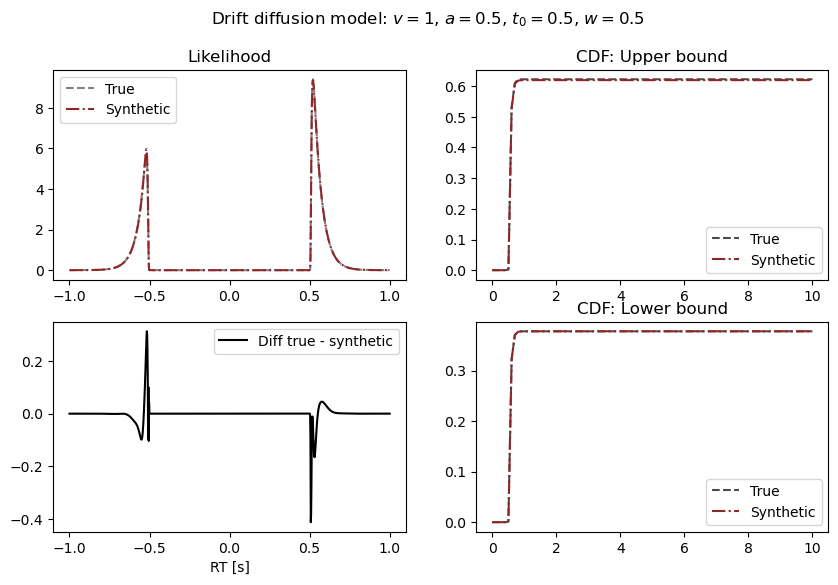

In [30]:
params = [1, 0.5, 0.5, 0.5]
f = compare_likelihoods_plot(params, max_rt=1)

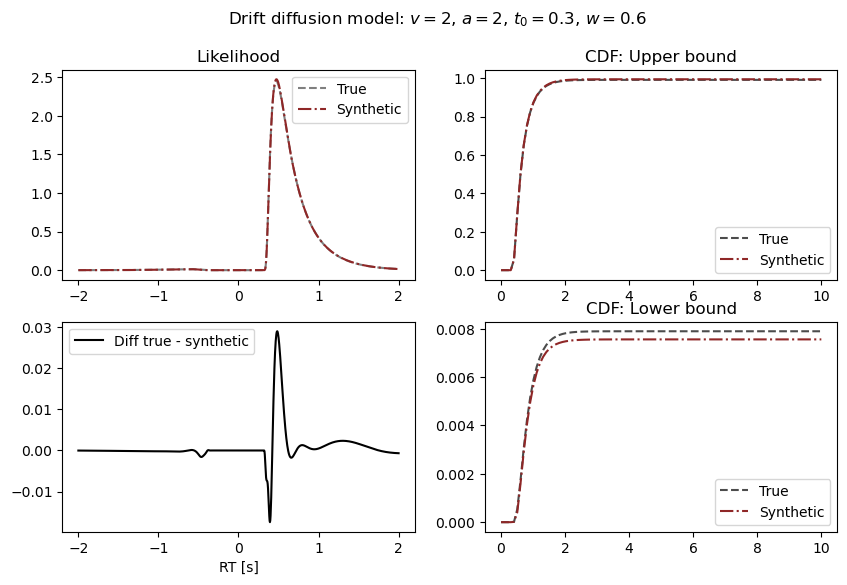

In [31]:
params = [2, 2, 0.3, 0.6]
f = compare_likelihoods_plot(params, max_rt=2)

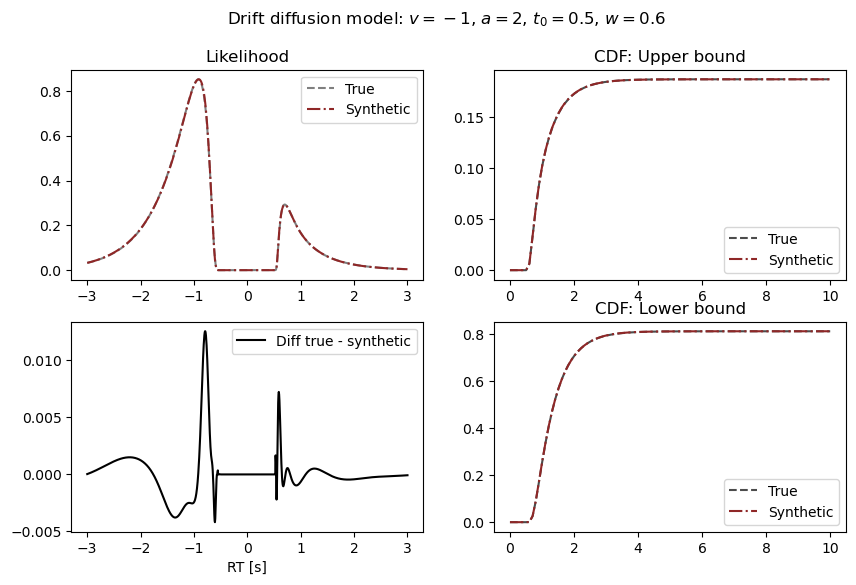

In [32]:
params = [-1, 2, 0.5, 0.6]
f = compare_likelihoods_plot(params, max_rt=3) 

Overall, we see good correspondance between the surrogate likelihood and the ground truth provided by `WienR`.

### Marginal likelihood
We can compute the marginal likelihood using the surrogate likelihood and samples form the posterior network. As the hard cuts from the truncated prior are hard to learn for the posterior network, there are samples that are incompatible with the prior. As we have the information on the prior available, we use it to remove any samples that have zero probability under the prior.

In [33]:
def marginal_likelihood(x_single, prior_dist, amortized_posterior, amortized_likelihood,
                        num_samples_posterior=2000, warn_excluded=True):
    """Helper function to compute approximate marginal likelihoods.  
    """
    N_ones = np.ones((1, 1))
    N_trials = x_single.shape[-2]
    approx_post_samples = amortized_posterior.sample({
        'summary_conditions': x_single[:,:1][np.newaxis],
        'direct_conditions': (N_ones * np.log(N_trials)).astype(np.float32)
        
    }, n_samples=num_samples_posterior)

    # Compute prior log pdf
    prior_lpdf = tf.reduce_sum(prior_dist.log_prob(approx_post_samples), axis=-1)
    # Problem: as prior is only approximated, posterior draws might lie in region
    # of zero prob. of prior ->  remove all samples with 0 probability under the prior.
    keep_idx = prior_lpdf != -np.inf
    num_remove = prior_lpdf.shape[0] - np.sum(keep_idx)
    approx_post_samples = approx_post_samples[keep_idx]
    prior_lpdf = prior_lpdf[keep_idx]
    if num_remove > 0 and warn_excluded:
        print(f"Info: {num_remove / prior_lpdf.shape[0] * 100:.1f}% of posterior samples"
              " removed due to prior probability density of zero.")
    # Approximate posterior lpdf
    N = x_single.shape[0]
    N_ones = np.ones((approx_post_samples.shape[0], 1))
    approx_post_lpdf = amortized_posterior.log_posterior(
        {
            'summary_conditions': np.stack([x_single[:,:1]] * approx_post_samples.shape[0], axis=0), 
            'parameters': approx_post_samples,
            'direct_conditions': (N_ones * np.log(N)).astype(np.float32)
        }
    )
    # Approximate log likelihood
    approx_log_likelihood = amortized_likelihood.log_likelihood(
        {'observables': np.stack([x_single] * approx_post_samples.shape[0], axis=0), 
         'conditions': approx_post_samples
    })
    
    # Approximate marginal log likelihood
    approx_marg_liks = approx_log_likelihood.sum(axis=-1) + prior_lpdf - approx_post_lpdf
    # average
    approx_marg_lik = tfp.math.reduce_logmeanexp(approx_marg_liks)
    return approx_marg_lik

In [34]:
N_LML = 100
marginal_likelihoods = np.zeros((N_LML))
for i in range(N_LML):
    print(f"{i+1:03}/{N_LML:03}\r", end="")
    x_single = val_dict['likelihood_inputs']['observables'][i]
    marginal_likelihoods[i] = marginal_likelihood(x_single, prior_dist, amortized_posterior,
                                                  amortized_likelihood, warn_excluded=False)

We can compare those values to the LML obtained from the Stan samples using bridge sampling. Refer to `bridge_sampling.R` for the corresponding code.

In [35]:
# Load values calculated with `loo` and `bridge_sampling`
bridge_sampling = pd.read_csv("assets/bmc_results_100.csv", sep=" ")

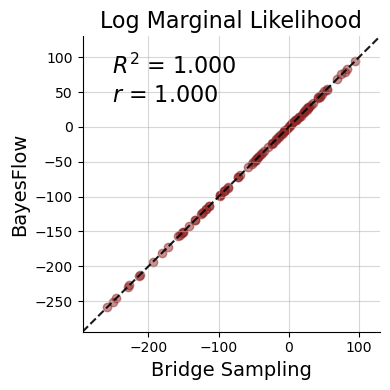

In [36]:
from plotting_functions import compare_point_estimates
f = compare_point_estimates(bridge_sampling['LML'][:N_LML].to_numpy()[:, np.newaxis],
                      marginal_likelihoods[:, np.newaxis],
                      label_x = "Bridge Sampling", label_y="BayesFlow",
                      param_names=["Log Marginal Likelihood"]
                     )
if save_figs: f.savefig(f'{fig_path}/LML_comparison.pdf', dpi=300)

### Leave-one-out cross-validation (LOO)
As we can obtain posterior samples at basically no cost, we can afford to make "real" leave-one-out cross-validation. If the likelihood is known, it can be used to calculate the likelihood of the left-out data point. If it isn't, we can use the trained likelihood network to evaluate the likelihood. This is demonstrated in this section and highlights another possibility of using posterior network and likelihood network together. As we get samples from the networks, we use Monte Carlo approximation to compute the results, as follows:

$$
\text{loo}=\sum_{m=1}^N\log\left(\frac{1}{S}\sum_{s=1}^S l(x_m|\theta_{x\setminus m}^{(s)})\right)
$$

In [37]:
def loo(x, amortized_posterior, amortized_likelihood, prior_dist,
        num_samples_posterior=2000, warn_excluded=True):
    """Helper function to compute leave-one-out cross-validation estimates
    """
    N_trials = x.shape[0]
    dim_x = x.shape[1]
    # Create N_trials data sets, each missing a different trial
    data_1 = np.stack([x[np.arange(N_trials) != i] for i in range(N_trials)])
    # calculate the posterior samples for each data set
    
    N_ones = np.ones((data_1.shape[0], 1))
    N = data_1.shape[1]
    approx_post_samples = amortized_posterior.sample({
        'summary_conditions': data_1[:,:,:1],
        'direct_conditions': (N_ones * np.log(N)).astype(np.float32)
    }, n_samples=num_samples_posterior)
    # calculate the log likelihood
    approx_log_likelihood = amortized_likelihood.log_likelihood(
        {'observables': np.stack([x] * num_samples_posterior, axis=1), 
         'conditions': approx_post_samples
    })
    # Remove samples with prior probability of zero for any parameter (combined using reduce_sum)
    prior_lpdf = tf.reduce_sum(prior_dist.log_prob(approx_post_samples), axis=-1)
    num_remove = np.sum(prior_lpdf == -np.inf)
    if num_remove > 0 and warn_excluded:
        print(f"Info: {num_remove / (prior_lpdf.shape[0] * prior_lpdf.shape[1]) * 100:.1f}% of posterior samples"
              " removed due to prior probability density of zero.")
    approx_loo = 0
    for i in range(N):
        keep_idx = prior_lpdf[i] != -np.inf
        # average on log scale: log(mean(exp(approx_log_likelihood)
        approx_loo += tfp.math.reduce_logmeanexp(approx_log_likelihood[i,keep_idx])
    return approx_loo

In [38]:
N_LOO = 100
loos = np.zeros((N_LOO))
for i in range(N_LOO):
    print(f"{i+1:03}/{N_LOO:03}\r", end="")
    x_single = val_dict['likelihood_inputs']['observables'][i]
    loos[i] = loo(x_single, amortized_posterior, amortized_likelihood,
                  prior_dist, warn_excluded=False)

Again, we compare to the current state of the art approximation technique, the Pareto-smoothed importance sampling leave-one-out crossvalidation. It's implemented using samples from Stan and the `loo` package in R. Refer to `bridge_sampling.R` for the corresponding code.

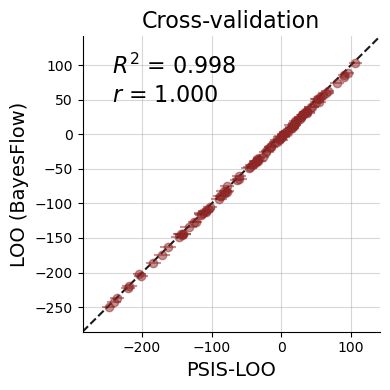

In [39]:
f = compare_point_estimates(bridge_sampling['ELPD'][:N_LOO].to_numpy()[:, np.newaxis],
                      loos[:,np.newaxis], label_x="PSIS-LOO", label_y="LOO (BayesFlow)",
                      u_x=bridge_sampling['ELPD_SE'][:N_LOO].to_numpy()[:, np.newaxis],
                      param_names=["Cross-validation"])
if save_figs: f.savefig(f'{fig_path}/LOO_PSIS-LOO_comparison.pdf', dpi=300)

The error bars on the PSIS-LOO values are hard to distinguish in the plot. By subtracting the LOO estimates obtained using BayesFlow, we get a more detailed picture. Thereby we can check whether the estimates are compatible given the PSIS-LOO standard error.

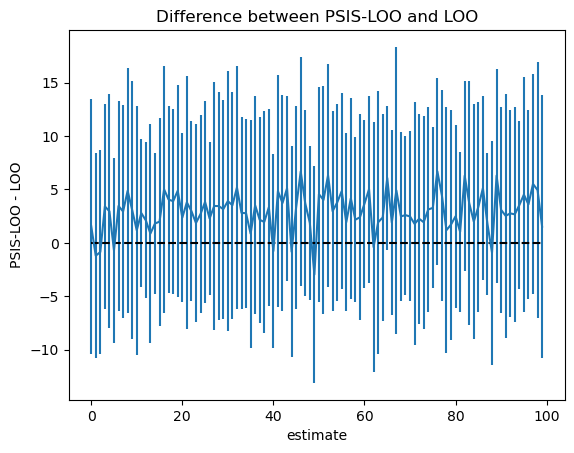

In [40]:
plt.errorbar(range(N_LOO), bridge_sampling['ELPD'][:N_LOO] - loos, yerr=bridge_sampling['ELPD_SE'][:N_LOO].to_numpy())
plt.hlines(0, xmin=0, xmax=N_LOO-1, colors="black", linestyles='dashed')
plt.xlabel('estimate')
plt.ylabel('PSIS-LOO - LOO')
_ = plt.title("Difference between PSIS-LOO and LOO")

In [41]:
np.all(
    np.abs((bridge_sampling['ELPD'][:N_LOO] - loos)) < bridge_sampling['ELPD_SE'][:N_LOO].to_numpy()
)

True

All differences are smaller than the corresponding standard error, indicating good correspondance between both methods.

## Links & References
- [BayesFlow](https://github.com/stefanradev93/BayesFlow)
- [Stan](https://mc-stan.org/)
- [PyMC](https://www.pymc.io/)
- [bridgesampling](https://github.com/quentingronau/bridgesampling)
- [PSIS-LOO (`loo`)](https://mc-stan.org/loo/articles/loo2-example.html): Vehtari, A., Gelman, A. & Gabry, J. Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. *Stat Comput* **27**, 1413--1432 (2017). https://doi.org/10.1007/s11222-016-9696-4
- Studentising Flows: Alexanderson, S., & Henter, G.. (2020). Robust model training and generalisation with Studentising flows.

## Appendix: Additional figures

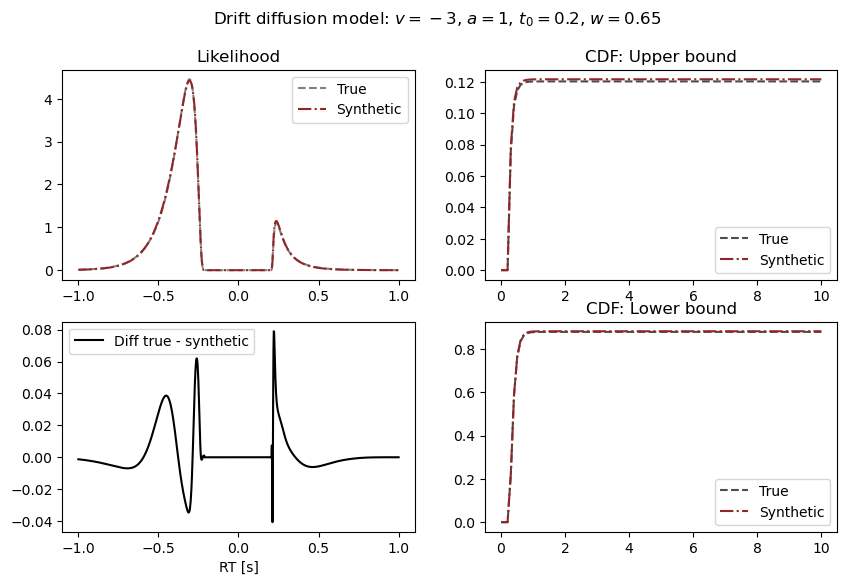

In [42]:
params = [-3, 1, 0.2, 0.65]
f = compare_likelihoods_plot(params, max_rt=1.0) 

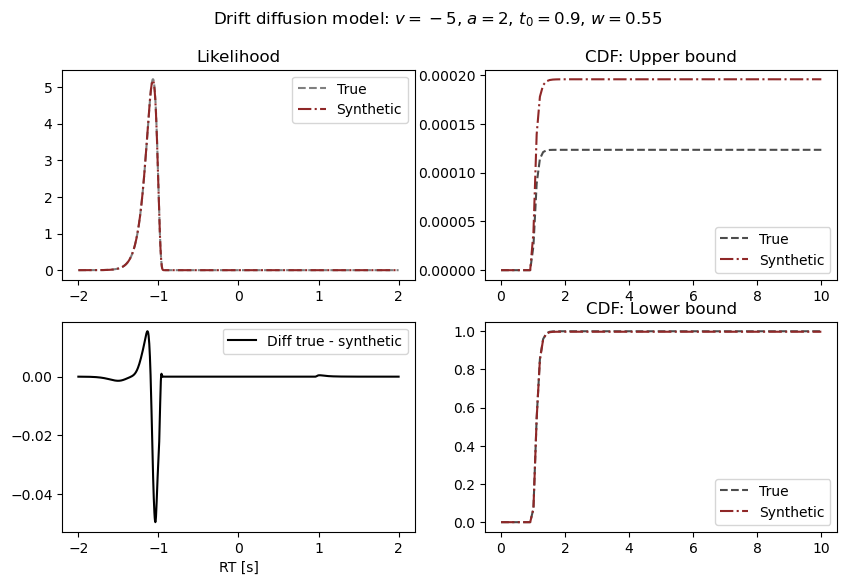

In [43]:
params = [-5, 2, 0.9, 0.55]
f = compare_likelihoods_plot(params, max_rt=2) 

A more compact form of this comparison:

In [44]:
def compare_likelihoods_small_plot(params, max_rt=10, resolution_pdf=1000, resolution_cdf=100,
                                   true_color='#000000', synthetic_color='#8f2727',
                                   label_fontsize=14, title_fontsize=16):
    rt_wienr = np.linspace(0.00001, max_rt, resolution_pdf // 2)
    # WienerPDF(t, response, a, v, w, t0, sv, sw, st0)
    ll_wienr_upper = r['WienerPDF'](FloatVector(rt_wienr), "upper", params[1], params[0], params[3], params[2]).rx2('logvalue')
    ll_wienr_lower = r['WienerPDF'](FloatVector(rt_wienr), "lower", params[1], params[0], params[3], params[2]).rx2('logvalue')
    ll_wienr = np.concatenate((np.flip(ll_wienr_lower), ll_wienr_upper))
    rt_wienr = np.concatenate((-np.flip(rt_wienr), rt_wienr))

    lik = ddm_synthetic_pdf(rt_wienr, params)

    fig = plt.figure()
    plt.title(f"DDM: $v={params[0]:.2f}$, $a={params[1]:.2f}$, $t_0={params[2]:.2f}$, $w={params[3]:.2f}$", fontsize=title_fontsize)
    plt.xlabel('RT [s]', fontsize=label_fontsize)
    plt.ylabel('likelihood', fontsize=label_fontsize)
    plt.plot(rt_wienr, np.exp(ll_wienr), label='True', linestyle='--', color=true_color, alpha=0.7)
    plt.plot(rt_wienr, lik, label='Synthetic', linestyle='-.', color=synthetic_color)
    plt.legend()
    return fig

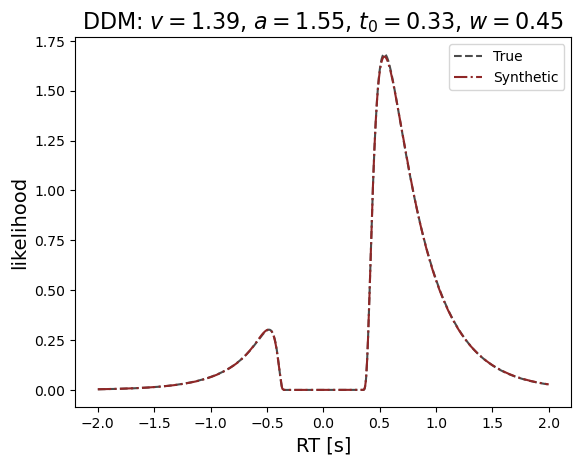

In [45]:
params = [float(p) for p in prior_samples[0]]
f = compare_likelihoods_small_plot(params, max_rt=2)
if save_figs: f.savefig(f'{fig_path}/Likelihood_comparison_01.pdf', dpi=300)

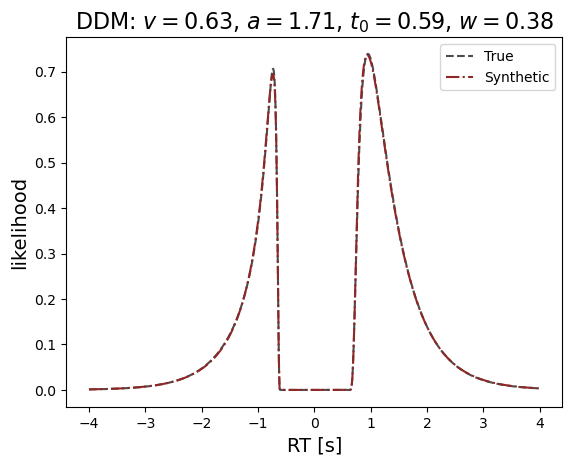

In [46]:
params = [float(p) for p in prior_samples[1]]
f = compare_likelihoods_small_plot(params, max_rt=4)
if save_figs: f.savefig(f'{fig_path}/Likelihood_comparison_02.pdf', dpi=300)

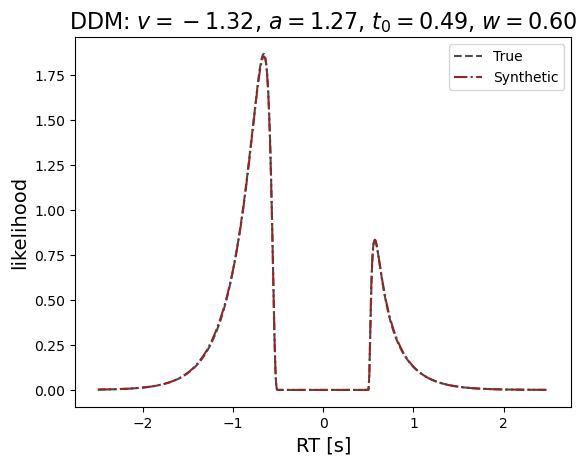

In [47]:
params = [float(p) for p in prior_samples[2]]
f = compare_likelihoods_small_plot(params, max_rt=2.5)
if save_figs: f.savefig(f'{fig_path}/Likelihood_comparison_03.pdf', dpi=300)

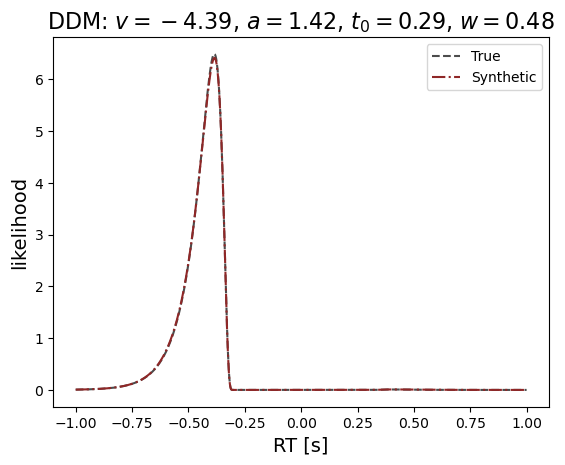

In [48]:
params = [float(p) for p in prior_samples[3]]
f = compare_likelihoods_small_plot(params, max_rt=1)
if save_figs: f.savefig(f'{fig_path}/Likelihood_comparison_04.pdf', dpi=300)